In [1]:
# Define a vector of package names to be used in the script
package_names_vec <- c(
  "tidyverse",
  "ggtext",
  "showtext",
  "readxl",
  "readxl",
  "srvyr",
  "viridis",
  "scales",
  "ggalluvial",
  "ggeffects",
  "emmeans"
)

# Define a function to install and load required packages
package_prep <- function(names_vec) {
  # Iterate through each package name in the provided vector
  for (name in names_vec) {
    # Check if the package is already installed
    if (!require(name, character.only = TRUE)) {
      # Install the package using renv if not already installed
      install.packages(name)
    }
  }
}

# Pipe the vector of package names into the package_prep function
package_names_vec |> package_prep()





if (grepl("kaggle", getwd())) {
  paths <- list(
    data = file.path("/kaggle", "input", "gfi-iran"),
    output = file.path("/kaggle", "working", "output"),
    temp = file.path("/kaggle", "working", "intermediate-data")
  )
} else {
  paths <- list(
    data = file.path("..", "data"),
    output = file.path("..", "output"),
    temp = file.path("..", "intermediate-data")
  )
  for (i in list.files(paths$data, full.names = TRUE)) {
    unzip(i, exdir = paths$data)
  }
  #file.rename(
  #  paths$data |> file.path("IRN_2017_FINDEX_v02_M_EXCEL\\micro_irn_varlabel.xls"),
  #  paths$data |> file.path("micro_irn_varlabel.xls")
  #)
  file.rename(
    paths$data |> file.path("IRN_2017_FINDEX_v02_M_EXCEL\\micro_irn_varname.xls"),
    paths$data |> file.path("micro_irn_varname.xls")
    )
}

Loading required package: tidyverse



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggtext

Loading required package: showtext

Loading required package: sysfonts

Loading required package: showtextdb

Loading required package: readxl

Loading required package: srvyr


Attaching package: ‘srvyr’


The following object is masked from ‘package:stats’:

    filter


Loading required package: viridis

Loading required package: viridisLite

Loading required package: scales


Attaching package: ‘scales’


The following object is maske

[1] TRUE

# Load the data and clean

In [2]:
# Define a function to load and process a table
# Parameters:
# - name: Name of the table to be assigned in the global environment
# - path: Path to the file to be read
# - argyear: Year to be added as a column in the resulting table
# - reading_func: Function to read the file (e.g., read_csv, read_excel)
load_tbl <- function(name, path, argyear, reading_func) {
  # Read the file, process it, and store it in a variable 'result'
  result <- file.path(path) |> # Generate the full file path
    reading_func() |> # Read the file using the provided reading function
    mutate(
      year = argyear, # Add a 'year' column with the specified year
      ID = row_number() # Add an 'ID' column with sequential row numbers
    ) |>
    select(where(~ !all(is.na(.x)))) # Select only the columns that are not entirely NA

  # Assign the processed table to the specified name in the global environment
  assign(name, result, envir = .GlobalEnv)
}

# Call the 'load_tbl' function to load and process data for the year 2021
load_tbl(
  "gfi_2021_tbl", # Name of the output table
  file.path(paths$data, "micro_irn.csv"), # File path
  2021, # Year to assign
  read_csv # Reading function
)

# Call the 'load_tbl' function to load and process data for the year 2017 (variable labels)
load_tbl(
  "gfi_2017_tbl", # Name of the output table
  file.path(paths$data, "micro_irn_varname.xls"), # File path
  2017, # Year to assign
  read_excel # Reading function
)


Rows: 1005 Columns: 84
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): economy, economycode
dbl (78): wpid_random, wgt, female, age, educ, inc_q, emp_in, account, accou...
lgl  (4): urbanicity_f2f, receive_agriculture, remittances, merchantpay_dig

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
gfi_2021_cleaned_tbl <- gfi_2021_tbl |>
  filter(female == 1) |>
  mutate(
    anydigpayment_s = as.integer(
      account == 1 & (
        account_mob == 1 | # 1
          fin4 == 1 | # 2
          fin8 == 1 | # 3
          (fin31a == 1 | (fin31b == 1 & account_mob == 1)) | # 4
          fin5 == 1 | # 5
          # fin27_1 == 1 | # 6
          (fin14a1 == 1 | fin14a == 1) | # (fin14b == 1 & (fin14c == 1 | fin14c == 3))) | # 7
          # fin29_1 == 1 | # 8
          # (fin43a == 1 | fin43b == 1) | # 9
          (fin34a == 1 | fin34b == 1 | fin34e == 1) | # 10
          ((fin37 == 1 & fin38 != 1) &
            ((fin39a == 1 | fin39e == 1) | fin39b == 1)) | # 11
          ((fin38 == 1) &
            ((fin39a == 1 | fin39e == 1) | fin39b == 1)) | # 12
          (fin14_1 == 1) # | fin8a == 1| fin4a == 1 13
      )
    ),
    pay_utilities_s = case_when(
      fin31a == 1 & !is.na(account_fin) ~ 1L, # from a FI account
      fin31b == 1 & !is.na(account_mob) ~ 1L, # …or from mobile money
      fin31c == 1 ~ 2L, # cash only
      fin30 == 1 ~ 3L, # other (non-cash, non-digital)
      fin30 == 2 ~ 4L, # did not pay
      fin30 %in% c(3, 4) ~ 5L, # DK / refused
      TRUE ~ NA_integer_
    ),
    receive_transfers_s = case_when(
      fin37 == 1 & fin39a == 1 & !is.na(account_fin) ~ 1L, # into FI account
      fin37 == 1 & fin39e == 1 & !is.na(account_fin) ~ 1L, # …or to a card
      fin37 == 1 & fin39b == 1 & !is.na(account_mob) ~ 1L, # …or mobile money
      fin37 == 1 & fin39d == 1 ~ 2L, # cash only
      fin37 == 1 ~ 3L, # other (non-cash, non-digital)
      fin37 == 2 ~ 4L, # did not receive
      fin37 %in% c(3, 4) ~ 5L, # DK / refused
      TRUE ~ NA_integer_
    ),
    receive_pension_s = case_when(
      fin38 == 1 & fin39a == 1 & !is.na(account_fin) ~ 1L, # into FI account
      fin38 == 1 & fin39e == 1 & !is.na(account_fin) ~ 1L, # …or to a card
      fin38 == 1 & fin39b == 1 & !is.na(account_mob) ~ 1L, # …or mobile money
      fin38 == 1 & fin39d == 1 ~ 2L, # cash only
      fin38 == 1 ~ 3L, # other (non-cash, non-digital)
      fin38 == 2 ~ 4L, # did not receive
      fin38 %in% c(3, 4) ~ 5L, # DK / refused
      TRUE ~ NA_integer_
    ),
    receive_wages_s = case_when(
      # 1: received into an account, card, or mobile
      (fin34a == 1 & !is.na(account_fin)) |
        (fin34e == 1 & !is.na(account_fin)) |
        (fin34b == 1 & !is.na(account_mob)) ~ 1,

      # 2: cash only (but only if not already coded 1)
      fin34d == 1 ~ 2,

      # 3: other methods
      fin32 == 1 ~ 3,

      # 4: did not receive payments
      fin32 == 2 ~ 0,
      TRUE ~ NA_real_
    )
  ) |>
  select(
    year, ID, wgt, age, educ, emp_in, inc_q, fin24,
    account, account_fin, account_mob, fin22a, borrowed,
    fin38, receive_pension_s,
    receive_transfers_s, pay_utilities_s, anydigpayment_s, receive_wages_s,
    mobileowner, saved, fin9, fin10,    fin11a,  # too far
    fin11b,  # too expensive
    fin11c,  # lack documentation
    fin11d,  # lack trust
    fin11e,  # religious reasons
    fin11f,  # lack money
    fin11g,  # family member has one
    fin11h   # no need
  ) |>
  rename(
    id = ID,
    weight = wgt,
    respondent_age = age,
    respondent_education_level = educ,
    household_income_quintile = inc_q,
    in_the_workforce = emp_in,
    main_source_emergency_funds = fin24,
    payments_utility_bills = pay_utilities_s,
    has_account = account,
    has_financial_institution_account = account_fin,
    has_mobile_money_account = account_mob,
    borrowed_in_past_year = borrowed,
    borrowed_from_financial_institution = fin22a,
    made_or_received_digital_payment = anydigpayment_s,
    payments_wage_payments = receive_wages_s,
    received_government_pension = fin38,
    received_government_transfers = receive_transfers_s,
    received_government_pension_payment = receive_pension_s,
    owns_mobile_phone = mobileowner,
    saved_in_past_year = saved,
    any_deposit_into_account = fin9,
    any_withdrawal_from_account = fin10,
    reason_too_far            = fin11a,
    reason_too_expensive      = fin11b,
    reason_no_documentation   = fin11c,
    reason_no_trust           = fin11d,
    reason_religious          = fin11e,
    reason_insufficient_funds = fin11f,
    reason_family_member      = fin11g,
    reason_no_need            = fin11h
  ) |>
  mutate(
    respondent_education_level = respondent_education_level - 1,
    household_income_quintile = household_income_quintile - 1,
    main_source_emergency_funds = main_source_emergency_funds |> case_match(
      1 ~ 1,
      2 ~ 2,
      3 ~ 3,
      4 ~ 4,
      5 ~ 5,
      6 ~ 6,
      7 ~ 0,
      .default = NA
    ),
    across(
      c(
        payments_utility_bills, received_government_transfers, received_government_pension_payment
      ),
      ~ case_match(
        .x,
        1 ~ 1,
        2 ~ 2,
        3 ~ 3,
        4 ~ 0,
        .default = NA
      )
    ),
    reason_no_account = case_when(
      reason_too_far            == 1 ~ 0L,
      reason_too_expensive      == 1 ~ 1L,
      reason_no_documentation   == 1 ~ 2L,
      reason_no_trust           == 1 ~ 3L,
      reason_religious          == 1 ~ 4L,
      reason_insufficient_funds == 1 ~ 5L,
      reason_family_member      == 1 ~ 6L,
      reason_no_need            == 1 ~ 7L,
      TRUE                             ~ NA_integer_
    ),
    across(
      c(
        received_government_pension,
        borrowed_from_financial_institution, in_the_workforce,
        owns_mobile_phone, saved_in_past_year, any_deposit_into_account, any_withdrawal_from_account
      ),
      ~ case_match(.x, 1 ~ 1, 2 ~ 0, 0 ~ 0, .default = NA_integer_)
    )
  ) |>
  mutate(
    borrowed_in_the_past_year = case_when(
      borrowed_in_past_year == 1 & borrowed_from_financial_institution == 0 ~ 1,
      borrowed_in_past_year == 1 & borrowed_from_financial_institution == 1 ~ 2,
      TRUE ~ borrowed_in_past_year
    )
  ) |>
  select(-c(borrowed_in_past_year, borrowed_from_financial_institution,,reason_too_far,reason_too_expensive,
  reason_no_documentation,reason_no_trust,reason_religious,reason_insufficient_funds,
  reason_family_member,reason_no_need))

In [23]:
gfi_2017_cleaned_tbl <- gfi_2017_tbl |>
  filter(female == "Female") |>
  mutate(
    account_mob_s = account_mob,
    across(
      c(
        fin4, fin8, fin5, account, fin31a, fin31b,
        fin14a, fin34a, fin34b, fin34c2, fin37, fin38,
        fin39a, fin39b, fin39c2, fin34a, fin34c2, fin34b, account_mob_s, fin34c1, fin32
      ),
      ~ case_match(.x, "yes" ~ 1, c("no", "0") ~ 0, .default = NA)
    ),
    anydigpayment_s = as.integer(
      account == 1 & (
        # Card and online account usage
        fin4 == 1 | # used debit card in past 12 months :contentReference[oaicite:0]{index=0}
          fin8 == 1 | # used credit card in past 12 months :contentReference[oaicite:1]{index=1}
          fin5 == 1 | # accessed FI account via mobile/internet :contentReference[oaicite:2]{index=2}

          # Utility‐bill payments
          fin31a == 1 | # paid utility by account :contentReference[oaicite:3]{index=3}
          fin31b == 1 | # paid utility by mobile phone :contentReference[oaicite:4]{index=4}

          # Internet bill payments
          fin14a == 1 | # made bill payments online :contentReference[oaicite:5]{index=5}

          # Wage‐payment channels
          fin34a == 1 | # wages into an account :contentReference[oaicite:6]{index=6}
          fin34b == 1 | # wages via mobile phone :contentReference[oaicite:7]{index=7}
          fin34c2 == 1 | # wages to a card :contentReference[oaicite:8]{index=8}

          # Government transfers (non-pension) via digital channels
          (fin37 == 1 & fin38 != 1) &
            (fin39a == 1 | fin39b == 1 | fin39c2 == 1) | # government transfer (not pension) :contentReference[oaicite:9]{index=9}

          # Government pensions via digital channels
          (fin38 == 1) &
            (fin39a == 1 | fin39b == 1 | fin39c2 == 1) # government pension :contentReference[oaicite:10]{index=10}
      )
    ),
    receive_wages_s = case_when(
      # 1: received into an account
      fin34a == 1 & !is.na(account_fin) ~ 1,
      # also 1: received onto a card
      fin34c2 == 1 & !is.na(account_fin) ~ 1,
      # also 1: received via mobile
      fin34b == 1 & !is.na(account_mob_s) ~ 1,
      # 2: cash only (only reached if none of the above matched)
      fin34c1 == 1 ~ 2,
      # 3: other methods only
      fin32 == 1 ~ 3,
      # 4: did not receive payments
      fin32 == 0 ~ 0,
      TRUE ~ NA_real_
    ),
  ) |>
  select(
    year, ID, wgt, age, educ, emp_in, inc_q, fin25, pay_utilities,
    account, account_fin, account_mob, fin22a, borrowed, anydigpayment_s,
    receive_wages_s, fin38, receive_transfers, receive_pension,
    mobileowner, saved, fin9, fin10,fin11a,fin11b,fin11c,fin11d,fin11e,fin11f,fin11g,fin11h
  ) |>
  rename(
    id = ID,
    weight = wgt,
    respondent_age = age,
    respondent_education_level = educ,
    household_income_quintile = inc_q,
    in_the_workforce = emp_in,
    main_source_emergency_funds = fin25,
    payments_utility_bills = pay_utilities,
    has_account = account,
    has_financial_institution_account = account_fin,
    has_mobile_money_account = account_mob,
    borrowed_in_past_year = borrowed,
    borrowed_from_financial_institution = fin22a,
    payments_wage_payments = receive_wages_s,
    received_government_pension = fin38,
    received_government_transfers = receive_transfers,
    received_government_pension_payment = receive_pension,
    made_or_received_digital_payment = anydigpayment_s,
    owns_mobile_phone = mobileowner,
    saved_in_past_year = saved,
    any_deposit_into_account = fin9,
    any_withdrawal_from_account = fin10,
    reason_too_far = fin11a,
    reason_too_expensive = fin11b,
    reason_no_documentation = fin11c,
    reason_no_trust = fin11d,
    reason_religious = fin11e,
    reason_insufficient_funds = fin11f,
    reason_family_member = fin11g,
    reason_no_need = fin11h
  ) |>
  mutate(
    respondent_education_level = respondent_education_level |> case_match(
      c("(rf)", "(dk)") ~ NA,
      "completed primary or less" ~ 0,
      "secondary" ~ 1,
      "completed tertiary or more" ~ 2
    ),
    household_income_quintile = household_income_quintile |> case_match(
      "Poorest 20%" ~ 0,
      "Middle 20%" ~ 1,
      "Fourth 20%" ~ 2,
      "Second 20%" ~ 3,
      "Richest 20%" ~ 4
    ),
    in_the_workforce = in_the_workforce |> case_match(
      "out of workforce" ~ 0,
      "in workforce" ~ 1
    ),
    main_source_emergency_funds = case_when(
      is.na(main_source_emergency_funds) ~ "0",
      TRUE ~ main_source_emergency_funds
    ),
    main_source_emergency_funds = main_source_emergency_funds |> case_match(
      "0" ~ 0,
      "Main source: Family or friends" ~ 2,
      "Main source: Borrowing from a bank, empoyer, or private lender" ~ 4,
      "Main source: Savings" ~ 1,
      "Main source: Money from working" ~ 3,
      "Main source: Selling assets" ~ 5,
      "Main source: Some other source" ~ 6,
      .default = NA
    ),
    across(
      c(received_government_pension_payment, payments_utility_bills, received_government_transfers),
      ~ case_match(.x, "1" ~ 1, "2" ~ 2, "3" ~ 3, "4" ~ 0, .default = NA)
    ),
    # recieve government pension payments
    # 1 "into an account" 2 "in cash" 3 "using other methods only" 0 "did not receive payments" NA "(dk)/ref",
    # recieve government transfers
    # 1 "into an account" 2 "in cash" 3 "using other methods only" 0 "did not receive payments" NA "(dk)/ref"
    # payments utility bills
    # 1 "into an account" 2 "in cash" 3 "using other methods only" 0 "did not receive payments" NA "(dk)/ref",
    across(
      c(
        has_financial_institution_account, has_mobile_money_account,
        borrowed_in_past_year, borrowed_from_financial_institution,
        owns_mobile_phone, saved_in_past_year, any_deposit_into_account, any_withdrawal_from_account,
        reason_too_far,reason_too_expensive,reason_no_documentation,reason_no_trust,reason_religious,
        reason_insufficient_funds,reason_family_member,reason_no_need
      ),
      ~ case_match(
        .x,
        c("no", "0") ~ 0,
        "yes" ~ 1,
        .default = NA
      )
    ),
    reason_no_account = case_when(
      reason_too_far              == 1 ~ 0L,
      reason_too_expensive        == 1 ~ 1L,
      reason_no_documentation     == 1 ~ 2L,
      reason_no_trust             == 1 ~ 3L,
      reason_religious            == 1 ~ 4L,
      reason_insufficient_funds   == 1 ~ 5L,
      reason_family_member        == 1 ~ 6L,
      reason_no_need              == 1 ~ 7L,
      TRUE                              ~ NA_integer_
    ),
    respondent_age = case_when(respondent_age == "99+" ~ "99", TRUE ~ respondent_age),
    across(-c(weight), ~ as.integer(.x))
  ) |>
  mutate(
    borrowed_in_the_past_year = case_when(
      borrowed_in_past_year == 1 & borrowed_from_financial_institution == 0 ~ 1,
      borrowed_in_past_year == 1 & borrowed_from_financial_institution == 1 ~ 2,
      TRUE ~ borrowed_in_past_year
    )
  ) |>
  select(-c(borrowed_in_past_year, borrowed_from_financial_institution,reason_too_far,reason_too_expensive,
  reason_no_documentation,reason_no_trust,reason_religious,reason_insufficient_funds,
  reason_family_member,reason_no_need))

In [24]:
gfi_tbl <- bind_rows(gfi_2017_cleaned_tbl, gfi_2021_cleaned_tbl)

In [25]:
gfi_renamed_tbl <- gfi_tbl |>
  rename(
    # index
    year_b = year,
    id_i = id,

    # continuous / double
    weight_d = weight,
    respondent_age_o = respondent_age,

    # ordinal
    respondent_education_level_o = respondent_education_level,
    household_income_quintile_o = household_income_quintile,
    borrowed_in_the_past_year_o = borrowed_in_the_past_year,

    # binary
    in_the_workforce_b = in_the_workforce,
    has_account_b = has_account,
    has_financial_institution_account_b = has_financial_institution_account,
    has_mobile_money_account_b = has_mobile_money_account,
    made_or_received_digital_payment_b = made_or_received_digital_payment,
    received_government_pension_b = received_government_pension,
    owns_mobile_phone_b = owns_mobile_phone,
    saved_in_past_year_b = saved_in_past_year,
    any_deposit_into_account_b = any_deposit_into_account,
    any_withdrawal_from_account_b = any_withdrawal_from_account,

    # categorical
    main_source_emergency_funds_c = main_source_emergency_funds,
    payments_utility_bills_c = payments_utility_bills,
    payments_wage_payments_c = payments_wage_payments,
    received_government_transfers_c = received_government_transfers,
    received_government_pension_payment_c = received_government_pension_payment,
    reason_no_account_c = reason_no_account
  )

# Discriptive Analysis of the Data

In [29]:
# 1. reshape to long
long_df <- gfi_renamed_tbl |>
  select(-id_i, -weight_d, -respondent_age_o) |>
  pivot_longer(
    cols      = -year_b,
    names_to  = "vars",
    values_to = "vals"
  )

# 2. counts + percentages per (vars, year, vals)
freq_tbl <- long_df |>
  count(vars, year_b, vals, name = "count") |>
  group_by(vars, year_b) |>
  mutate(
    percent = count / sum(count) * 100
  ) |>
  ungroup()

# 3. medians + means per (vars, year)
stats_tbl <- long_df |>
  group_by(vars, year_b) |>
  summarise(
    median = median(vals, na.rm = TRUE),
    mean = mean(vals, na.rm = TRUE),
    .groups = "drop"
  )

# 4. grab the two years
yrs <- sort(unique(long_df$year_b))
yr1 <- yrs[1]
yr2 <- yrs[2]

# 5. join, pivot wider, then compute growths
result_tbl <- freq_tbl |>
  left_join(stats_tbl, by = c("vars", "year_b")) |>
  pivot_wider(
    names_from   = year_b,
    values_from  = c(count, percent, median, mean),
    names_glue   = "{.value}_{year_b}"
  ) |>
  mutate(
    growth_count = .data[[paste0("count_", yr2)]] - .data[[paste0("count_", yr1)]],
    pct_growth_count = growth_count / .data[[paste0("count_", yr1)]] * 100,
    pct_growth_avg = (.data[[paste0("mean_", yr2)]] - .data[[paste0("mean_", yr1)]]) /
      .data[[paste0("mean_", yr1)]] * 100
  )

# take a look
result_tbl |> print(n=100)

# A tibble: 74 × 13
   vars         vals count_2017 count_2021 percent_2017 percent_2021 median_2017
   <chr>       <dbl>      <int>      <int>        <dbl>        <dbl>       <dbl>
 1 any_deposi…     0        121        113       22.4         21.8             1
 2 any_deposi…     1        306        324       56.8         62.5             1
 3 any_deposi…    NA        112         81       20.8         15.6             1
 4 any_withdr…     0         83         92       15.4         17.8             1
 5 any_withdr…     1        343        344       63.6         66.4             1
 6 any_withdr…    NA        113         82       21.0         15.8             1
 7 borrowed_i…     0        149        215       27.6         41.5             1
 8 borrowed_i…     1        231        198       42.9         38.2             1
 9 borrowed_i…     2        159        105       29.5         20.3             1
10 has_accoun…     0         43         57        7.98        11.0             1
11 has_a

In [8]:
gfi_renamed_tbl |> names()

[1] "year_b"                               
 [2] "id_i"                                 
 [3] "weight_d"                             
 [4] "respondent_age_o"                     
 [5] "respondent_education_level_o"         
 [6] "in_the_workforce_b"                   
 [7] "household_income_quintile_o"          
 [8] "main_source_emergency_funds_c"        
 [9] "payments_utility_bills_c"             
[10] "has_account_b"                        
[11] "has_financial_institution_account_b"  
[12] "has_mobile_money_account_b"           
[13] "made_or_received_digital_payment_b"   
[14] "payments_wage_payments_c"             
[15] "received_government_pension_b"        
[16] "received_government_transfers_c"      
[17] "received_government_pension_payment_c"
[18] "owns_mobile_phone_b"                  
[19] "saved_in_past_year_b"                 
[20] "any_deposit_into_account_b"           
[21] "any_withdrawal_from_account_b"        
[22] "borrowed_in_the_past_year_o"

In [21]:
gfi_2021_tbl  |> 
  select(
    fin11a,  # too far
    fin11b,  # too expensive
    fin11c,  # lack documentation
    fin11d,  # lack trust
    fin11e,  # religious reasons
    fin11f,  # lack money
    fin11g,  # family member has one
    fin11h   # no need
  ) |> map(~unique(.x))

$fin11a
[1] NA  2  3  1

$fin11b
[1] NA  2  3  1

$fin11c
[1] NA  2  3  1

$fin11d
[1] NA  2  1  3  4

$fin11e
[1] NA  2  3  1

$fin11f
[1] NA  2  1

$fin11g
[1] NA  1  3  2

$fin11h
[1] NA  1  3  2

# plots

## Good ones

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


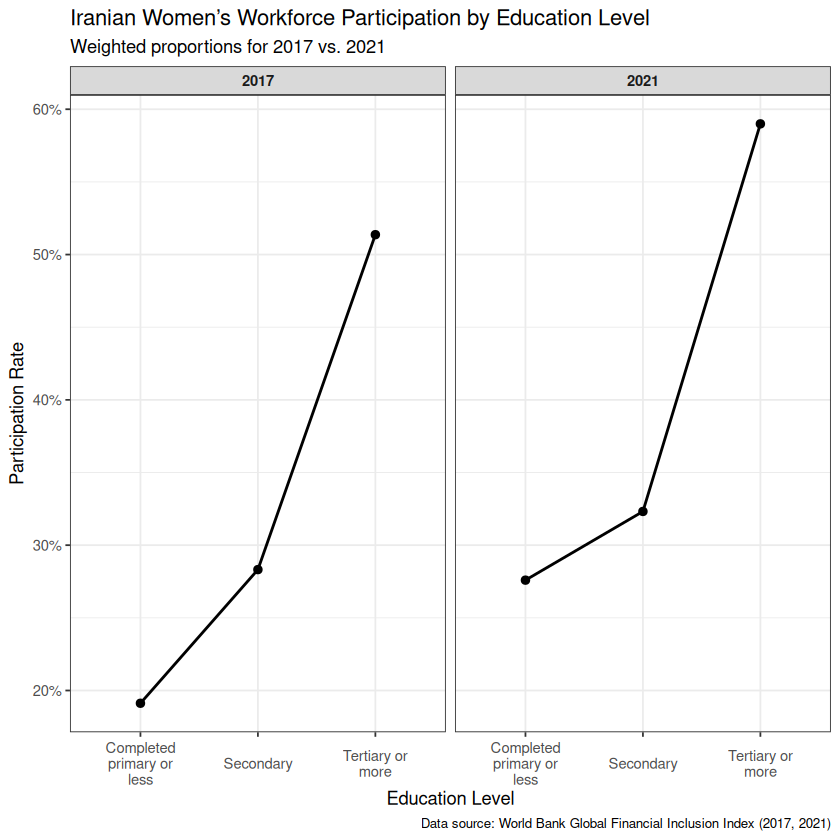

In [9]:
education_plot <- gfi_renamed_tbl |>
  filter(!is.na(respondent_education_level_o)) |>
  mutate(
    education = factor(
      respondent_education_level_o,
      levels = c(0, 1, 2),
      labels = c(
        "Completed primary or less",
        "Secondary",
        "Tertiary or more"
      )
    )
  ) |>
  group_by(year_b, education) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  ggplot(aes(
    x     = education,
    y     = participation,
    group = 1
  )) +
  geom_line(size = 0.8) +
  geom_point(size = 2) +
  facet_wrap(~ year_b) +
  scale_x_discrete(labels = wrap_format(15)) +   # wrap at ~15 characters
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  labs(
    title    = "Iranian Women’s Workforce Participation by Education Level",
    subtitle = "Weighted proportions for 2017 vs. 2021",
    x        = "Education Level",
    y        = "Participation Rate",
    caption  = "Data source: World Bank Global Financial Inclusion Index (2017, 2021)"
  ) +
  theme_bw() +
  theme(
    strip.text     = element_text(face = "bold"),
    axis.text.x    = element_text(angle = 0, vjust = 0.5, hjust = 0.5),  # no tilt
    plot.caption   = element_text(hjust = 1, size = 8)
  )

education_plot


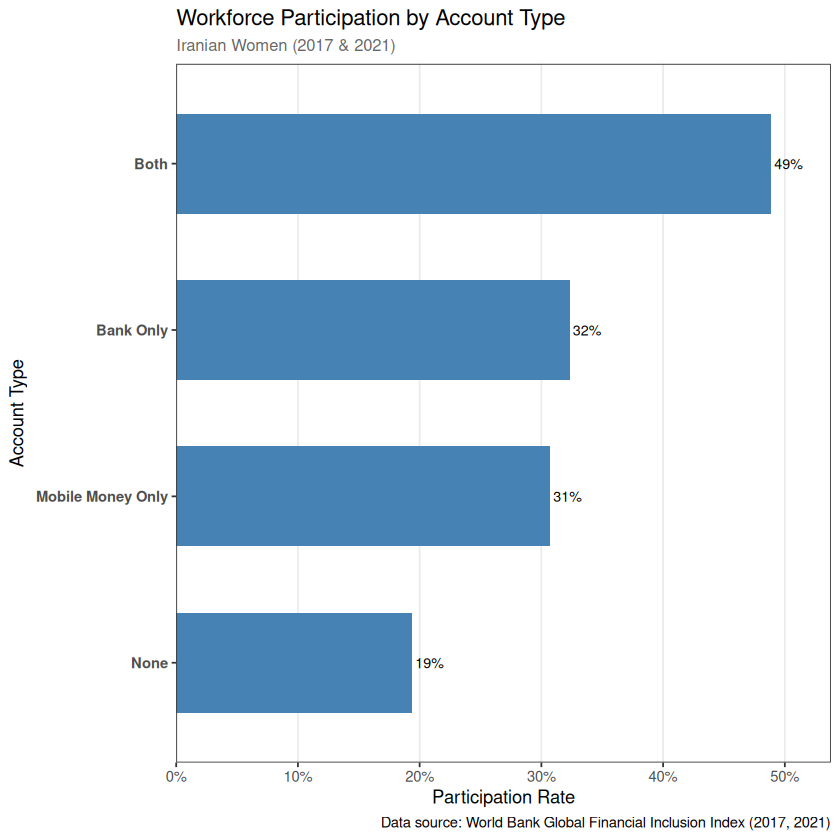

In [10]:
account_plot <- gfi_renamed_tbl |>
  mutate(
    account_type = case_when(
      has_financial_institution_account_b == 1 & has_mobile_money_account_b == 1 ~ "Both",
      has_financial_institution_account_b == 1                            ~ "Bank Only",
      has_mobile_money_account_b == 1                                    ~ "Mobile Money Only",
      TRUE                                                              ~ "None"
    )
  ) |>
  group_by(account_type) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  # Make sure we order from lowest to highest participation
  mutate(account_type = fct_reorder(account_type, participation)) |>
  ggplot(aes(x = account_type, y = participation)) +
    geom_col(width = 0.6, fill = "steelblue") +
    geom_text(
      aes(label = percent(participation, accuracy = 1)),
      hjust = -0.1,
      size = 3
    ) +
    scale_y_continuous(
      labels = percent_format(accuracy = 1),
      expand = expansion(mult = c(0, 0.1))
    ) +
    labs(
      title    = "Workforce Participation by Account Type",
      subtitle = "Iranian Women (2017 & 2021)",
      x        = "Account Type",
      y        = "Participation Rate",
      caption  = "Data source: World Bank Global Financial Inclusion Index (2017, 2021)"
    ) +
    theme_bw() +
    theme(
      panel.grid.major.y = element_blank(),
      panel.grid.minor   = element_blank(),
      axis.text.y        = element_text(face = "bold"),
      plot.subtitle      = element_text(size = rel(0.9), color = "gray40")
    ) +
    coord_flip()

account_plot


## Shitty ones

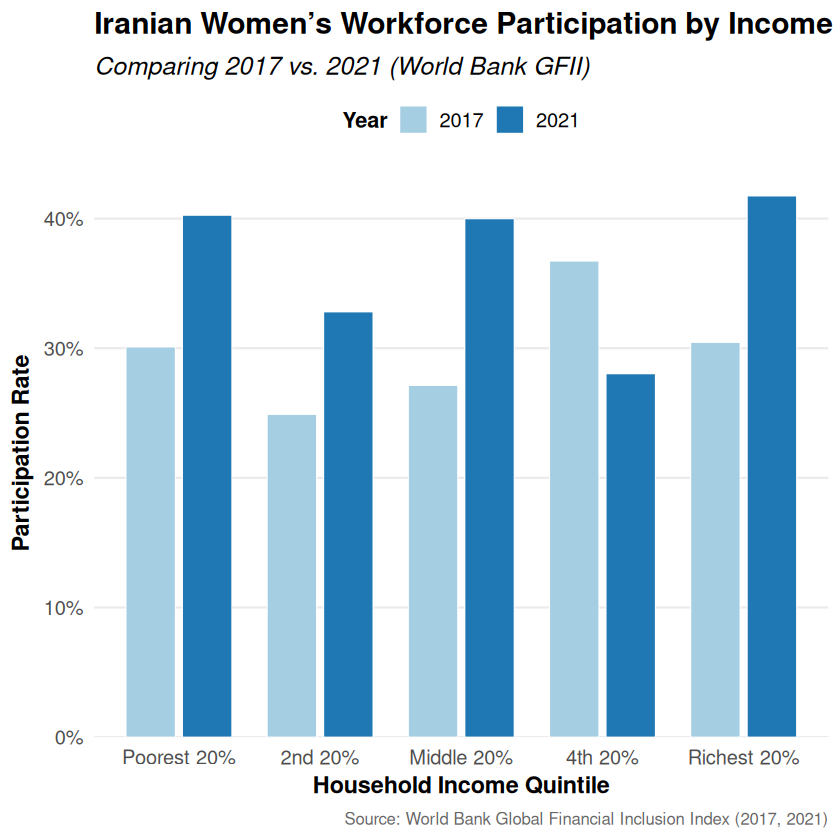

In [11]:
income_plot <- gfi_renamed_tbl |>
  filter(!is.na(household_income_quintile_o)) |>
  group_by(year_b, household_income_quintile_o) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  mutate(
    household_income_quintile = factor(
      household_income_quintile_o,
      levels = 0:4,
      labels = c(
        "Poorest 20%",
        "2nd 20%",
        "Middle 20%",
        "4th 20%",
        "Richest 20%"
      )
    ),
    year = factor(year_b)
  ) |>
  ggplot(aes(
    x    = household_income_quintile,
    y    = participation,
    fill = year
  )) +
    geom_col(
      position = position_dodge(width = 0.8),
      width    = 0.7,
      colour   = "white",     # crisp bar outlines
      size     = 0.3
    ) +
    scale_fill_brewer(
      palette = "Paired",     # a clean 2-colour palette
      name    = "Year",
      labels  = c("2017", "2021")
    ) +
    scale_y_continuous(
      labels = percent_format(accuracy = 1),
      expand = expansion(mult = c(0, 0.05))
    ) +
    labs(
      title    = "Iranian Women’s Workforce Participation by Income Quintile",
      subtitle = "Comparing 2017 vs. 2021 (World Bank GFII)",
      x        = "Household Income Quintile",
      y        = "Participation Rate",
      caption  = "Source: World Bank Global Financial Inclusion Index (2017, 2021)"
    ) +
    theme_minimal(base_size = 14) +  # larger base font
    theme(
      legend.position       = "top",
      legend.title          = element_text(size = 13, face = "bold"),
      legend.text           = element_text(size = 12),
      plot.title            = element_text(size = 18, face = "bold", margin = margin(b = 10)),
      plot.subtitle         = element_text(size = 15, face = "italic", margin = margin(b = 8)),
      plot.caption          = element_text(size = 10, color = "gray40", margin = margin(t = 8)),
      axis.title.x          = element_text(size = 14, face = "bold", margin = margin(t = 6)),
      axis.title.y          = element_text(size = 14, face = "bold", margin = margin(r = 6)),
      axis.text.x           = element_text(size = 12, angle = 0, vjust = 0.5),
      axis.text.y           = element_text(size = 12),
      panel.grid.major.x    = element_blank(),
      panel.grid.minor      = element_blank()
    )

income_plot


## Need polisihing

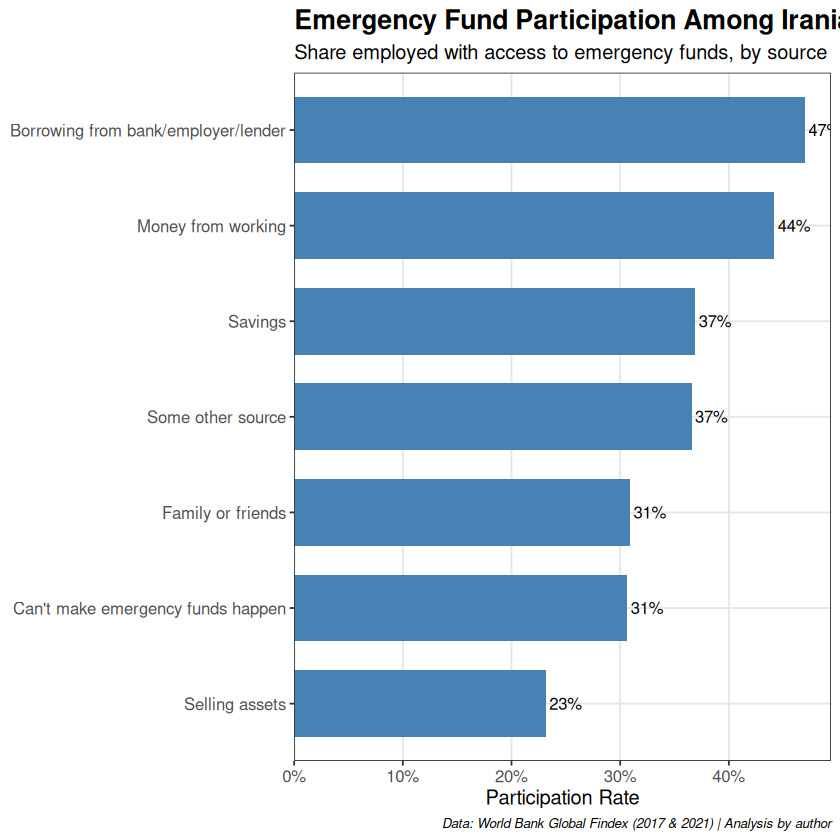

In [12]:
# mapping codes → full labels
fund_labels <- c(
  "0" = "Can't make emergency funds happen",
  "1" = "Savings",
  "2" = "Family or friends",
  "3" = "Money from working",
  "4" = "Borrowing from bank/employer/lender",
  "5" = "Selling assets",
  "6" = "Some other source"
)

funds_plot <- gfi_renamed_tbl |>
  filter(!is.na(main_source_emergency_funds_c)) |>
  group_by(main_source_emergency_funds_c) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  ggplot(aes(
    x = participation,
    y = reorder(main_source_emergency_funds_c, participation)
  )) +
  geom_col(width = 0.7, fill = "steelblue") +
  geom_text(
    aes(label = percent(participation, accuracy = 1)),
    hjust = -0.1,
    size  = 3.5,
    color = "black"
  ) +
  scale_y_discrete(labels = fund_labels) +
  scale_x_continuous(
    labels = percent_format(accuracy = 1),
    expand = expansion(mult = c(0, 0.05))
  ) +
  labs(
    title    = "Emergency Fund Participation Among Iranian Women",
    subtitle = "Share employed with access to emergency funds, by source",
    x        = "Participation Rate",
    y        = NULL,
    caption  = "Data: World Bank Global Findex (2017 & 2021) | Analysis by author"
  ) +
  theme_bw(base_size = 11) +
  theme(
    plot.title    = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12),
    axis.text.y   = element_text(size = 10),
    axis.text.x   = element_text(size = 10),
    axis.title.x  = element_text(size = 12),
    plot.caption  = element_text(size = 8, face = "italic"),
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor = element_blank()
  )

funds_plot


Warning message:
“Removed 38 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 38 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


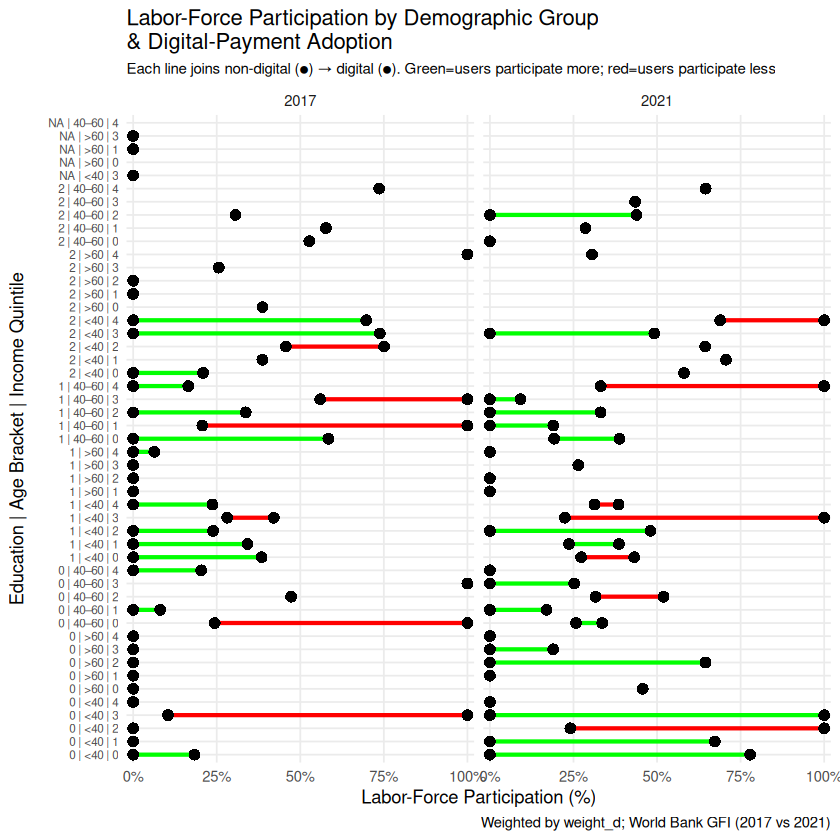

In [13]:
#–– 1. Compute weighted labor-force rates by group & digital-payment status ––#
demo_lollipop <- gfi_renamed_tbl |>
  # Create the age brackets and a single “demo” label
  mutate(
    age_bracket = case_when(
      respondent_age_o < 40                 ~ "<40",
      respondent_age_o >= 40 & respondent_age_o <= 60 ~ "40–60",
      respondent_age_o > 60                 ~ ">60"
    ),
    education     = factor(respondent_education_level_o),
    income_quint  = factor(household_income_quintile_o),
    demo          = paste(education, age_bracket, income_quint, sep = " | ")
  ) |>
  # Declare survey design with weights
  as_survey_design(weights = weight_d) |>
  # Group by year, demo, and digital-payment flag
  group_by(year_b, demo, made_or_received_digital_payment_b) |>
  # Compute weighted mean labor-force participation
  summarise(
    labor_part = survey_mean(in_the_workforce_b, vartype = NULL)
  ) |>
  ungroup() |>
  # Pivot so each row has dp_0 and dp_1
  pivot_wider(
    id_cols     = c(year_b, demo),
    names_from   = made_or_received_digital_payment_b,
    values_from  = labor_part,
    names_prefix = "dp_"
  ) |>
  # Color logic: green if dp_1 > dp_0, else red
  mutate(
    line_color = ifelse(dp_1 > dp_0, "green", "red")
  )

#–– 2. Plot faceted lollipop chart ––#
ggplot(demo_lollipop, aes(y = demo)) +
  # connecting segment
  geom_segment(aes(x = dp_0, xend = dp_1, yend = demo, color = line_color),
               size = 1.2) +
  # two end-points
  geom_point(aes(x = dp_0), size = 3, shape = 16) +
  geom_point(aes(x = dp_1), size = 3, shape = 16) +
  # use exact “green”/“red” strings
  scale_color_identity() +
  # format x-axis as percent
  scale_x_continuous(labels = percent_format(accuracy = 1),
                     expand = expansion(mult = c(0.02, 0.02))) +
  # side-by-side facets
  facet_wrap(~ year_b, nrow = 1) +
  # full labeling
  labs(
    title    = "Labor-Force Participation by Demographic Group\n& Digital-Payment Adoption",
    subtitle = "Each line joins non-digital (●) → digital (●). Green=users participate more; red=users participate less",
    x        = "Labor-Force Participation (%)",
    y        = "Education | Age Bracket | Income Quintile",
    caption  = "Weighted by weight_d; World Bank GFI (2017 vs 2021)"
  ) +
  theme_minimal(base_size = 11) +
  theme(
    axis.text.y    = element_text(size = 7),
    axis.title.y   = element_text(margin = margin(r = 10)),
    plot.subtitle  = element_text(size = 9),
    panel.grid.minor = element_blank()
  )


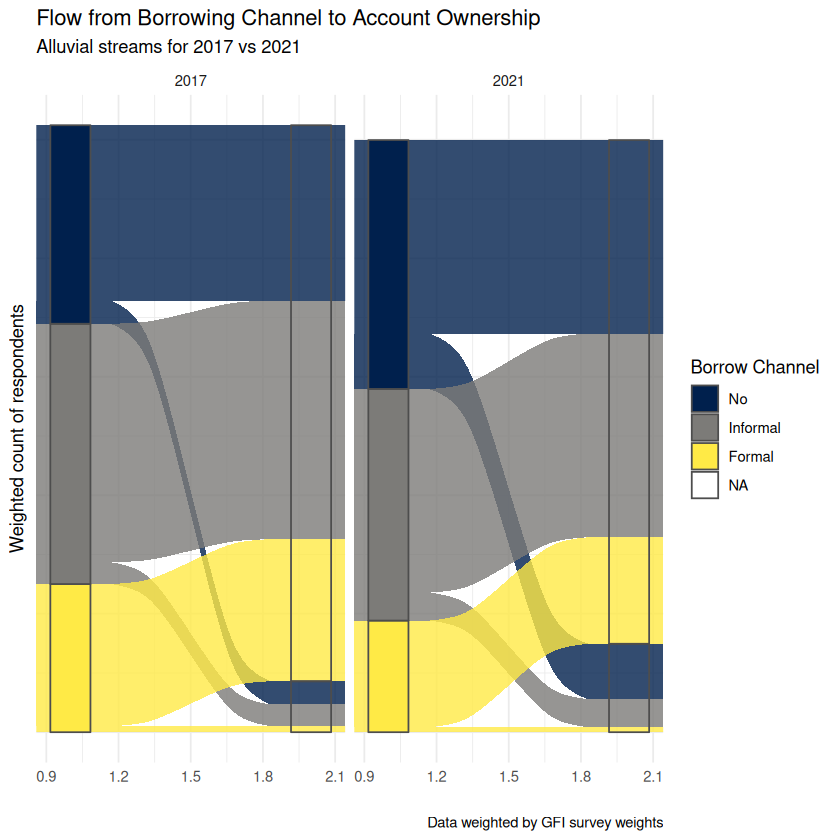

In [14]:
library(ggalluvial)

# prepare data: count weighted flows
alluv <- gfi_renamed_tbl %>%
  mutate(
    borrow = factor(borrowed_in_the_past_year_o,
      labels = c("No","Informal","Formal")),
    has_acct = if_else(has_account_b==1, "Has account","No account")
  ) %>%
  as_survey_design(weights = weight_d) %>%
  group_by(borrow, has_acct, year_b) %>%
  summarise(flow = survey_total(vartype=NULL)) %>%
  ungroup()

ggplot(alluv, aes(
    axis1 = borrow, axis2 = has_acct,
    y = flow, fill = borrow
  )) +
  geom_alluvium(alpha = 0.8) +
  geom_stratum(width = 1/6, color = "grey30") +
  facet_wrap(~ year_b) +
  scale_fill_viridis_d(name="Borrow Channel", option="E") +
  labs(
    title    = "Flow from Borrowing Channel to Account Ownership",
    subtitle = "Alluvial streams for 2017 vs 2021",
    x        = "",
    y        = "Weighted count of respondents",
    caption  = "Data weighted by GFI survey weights"
  ) +
  theme_minimal() +
  theme(axis.text.y = element_blank())


Loading required package: grid

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart




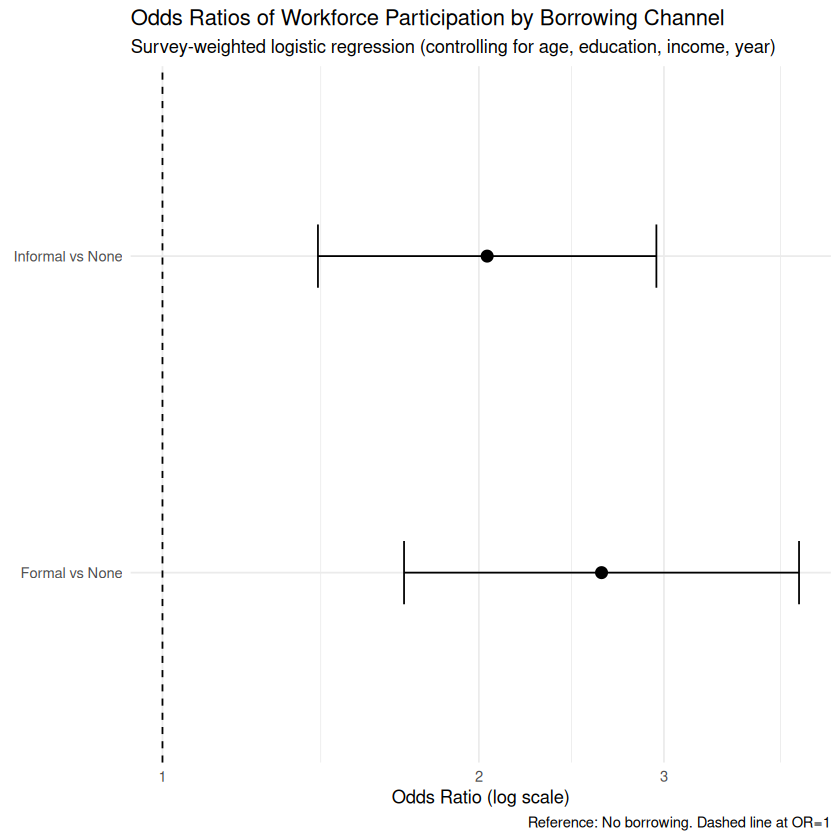

In [15]:
library(survey); library(broom); library(ggplot2)

# 1. Build survey design (survey package)
svy <- svydesign(ids = ~1, weights = ~weight_d, data = gfi_renamed_tbl)

# 2. Fit weighted logistic regression (pooling years, with interaction if desired)
mod <- svyglm(in_the_workforce_b ~ factor(borrowed_in_the_past_year_o)
              + respondent_age_o
              + respondent_education_level_o
              + household_income_quintile_o
              + factor(year_b),
              design = svy, family = quasibinomial())

# 3. Tidy and exponentiate to get ORs
or_tab <- broom::tidy(mod) %>%
  filter(term %in% c("factor(borrowed_in_the_past_year_o)1",
                     "factor(borrowed_in_the_past_year_o)2")) %>%
  mutate(
    OR  = exp(estimate),
    LCI = exp(estimate - 1.96*std.error),
    UCI = exp(estimate + 1.96*std.error),
    borrow_cat = c("Informal vs None","Formal vs None")
  )

# 4. Forest plot
ggplot(or_tab, aes(x = OR, y = borrow_cat)) +
  geom_point(size = 3) +
  geom_errorbarh(aes(xmin = LCI, xmax = UCI), height = 0.2) +
  geom_vline(xintercept = 1, linetype = "dashed") +
  scale_x_log10() +
  labs(
    title    = "Odds Ratios of Workforce Participation by Borrowing Channel",
    subtitle = "Survey‐weighted logistic regression (controlling for age, education, income, year)",
    x        = "Odds Ratio (log scale)",
    y        = NULL,
    caption  = "Reference: No borrowing. Dashed line at OR=1"
  ) +
  theme_minimal()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# FINANCIAL‐INCLUSION CHANNELS → WORKFORCE PARTICIPATION
# POOLED OVER 2017 & 2021
# ─────────────────────────────────────────────────────────────────────────────

# 0) LOAD PACKAGES -------------------------------------------------------------
library(tidyverse)    # dplyr, ggplot2, etc.
library(survey)       # svydesign, svyglm
library(emmeans)      # emmeans for marginal predictions
library(ggalluvial)   # alluvial plots
library(viridis)      # color‐blind palettes
library(scales)       # percent_format

# 1) PREPARE DATA: Factorize & New Flags ---------------------------------------

gfi_prep <- gfi_renamed_tbl %>%
  # 1a) Borrowing & Saving factors
  mutate(
    borrowed_f = factor(
      borrowed_in_the_past_year_o,
      levels = c(0,1,2),
      labels = c("None","Informal","Formal")
    ),
    saved_f = factor(
      saved_in_the_past_year_b,
      levels = c(0,1),
      labels = c("No","Yes")
    ),
    # 1b) Emergency‐fund source factor
    emerg_f = factor(
      main_source_emergency_funds_c,
      levels = 0:6,
      labels = c("None","Savings","Family/Friends","Work",
                 "FinInst","Assets","Other")
    ),
    # 1c) Account/Mobile channel
    channel_f = case_when(
      has_financial_institution_account_b==1 &
      has_mobile_money_account_b       ==1 ~ "Both",
      has_financial_institution_account_b==1 ~ "Bank only",
      has_mobile_money_account_b       ==1 ~ "Mobile only",
      TRUE                                  ~ "Neither"
    ) %>% factor(levels=c("Neither","Bank only","Mobile only","Both")),
    # 1d) Workforce factor (for plotting)
    workforce_f = factor(
      in_the_workforce_b,
      levels = c(0,1),
      labels = c("No","Yes")
    ),
    # 1e) Pensions/Transfers in account
    recv_account = if_else(
      received_government_pension_payment_c==1 |
      received_government_transfers_c      ==1,
      1, 0
    ) %>% factor(levels=c(0,1), labels=c("No","Yes"))
  )

# 2) BUILD SURVEY DESIGN -------------------------------------------------------
gfi_design <- svydesign(
  ids     = ~1,
  weights = ~weight_d,
  data    = gfi_prep
)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 1: HEATMAP of Borrowing_f × Saved_f → Workforce
# ─────────────────────────────────────────────────────────────────────────────

mod1 <- svyglm(
  in_the_workforce_b ~ borrowed_f * saved_f,
  design = gfi_design,
  family = quasibinomial()
)

emm1 <- emmeans(
  mod1,
  ~ borrowed_f * saved_f,
  type = "response"
)
preds1 <- as.data.frame(emm1) %>%
  rename(prob = response)

ggplot(preds1, aes(x=borrowed_f, y=saved_f, fill=prob)) +
  geom_tile() +
  geom_text(aes(label=percent(prob,1)), color="white", size=3) +
  scale_fill_viridis_c(name="P(In Workforce)") +
  labs(
    title    = "Workforce Participation by Borrowing & Saving",
    subtitle = "Predicted probabilities (survey‐weighted, pooled 2017+2021)",
    x        = "Borrowing Source",
    y        = "Saved in Past Year",
    caption  = "Model: svyglm with interaction"
  ) +
  theme_minimal()

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 2: ALLUVIAL of channel_f → workforce_f
# ─────────────────────────────────────────────────────────────────────────────

df2 <- gfi_prep %>%
  group_by(channel_f, workforce_f) %>%
  summarise(wt = sum(weight_d), .groups="drop")

ggplot(df2,
       aes(axis1=channel_f, axis2=workforce_f, y=wt)) +
  scale_x_discrete(labels=c("Channel","In Workforce"),
                   expand=c(.15,.15)) +
  geom_alluvium(aes(fill=channel_f), width=1/12) +
  geom_stratum(width=1/12, fill="grey80") +
  geom_text(stat="stratum", aes(label=after_stat(stratum)), size=3) +
  scale_fill_viridis_d(name="Channel") +
  labs(
    title    = "Account/Mobile‐Money Channel → Workforce Status",
    subtitle = "Flows ∝ pooled survey weights",
    caption  = "Data: Iranian women, GFI 2017 & 2021"
  ) +
  theme_minimal() +
  theme(legend.position="none")


ERROR: [1m[33mError[39m in `rename()`:[22m
[33m![39m Can't rename columns that don't exist.
[31m✖[39m Column `response` doesn't exist.


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# PLOT 5: CLUSTER PROFILES → Workforce Rates
# ─────────────────────────────────────────────────────────────────────────────

# 5a) Numeric feature matrix (no factors here)
feat_mat <- model.matrix(
  ~ borrowed_in_the_past_year_o +
    saved_in_the_past_year_b +
    main_source_emergency_funds_c +
    has_financial_institution_account_b +
    has_mobile_money_account_b +
    made_or_received_digital_payment_b +
    received_government_pension_payment_c +
    received_government_transfers_c,
  data = gfi_prep
)[, -1]

# 5b) k‐means (k=3)
set.seed(2025)
km <- kmeans(scale(feat_mat), centers=3, nstart=25)
gfi_prep$cluster <- factor(km$cluster, labels=c("Profile 1","Profile 2","Profile 3"))

# 5c) Workforce rate by cluster
df5 <- gfi_prep %>%
  group_by(cluster) %>%
  summarise(
    p_wrk = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups="drop"
  )

ggplot(df5, aes(x=cluster, y=p_wrk, fill=cluster)) +
  geom_col(width=0.6) +
  scale_y_continuous(labels=percent_format(1)) +
  labs(
    title   = "Workforce Participation by Inclusion Profile",
    x       = "Cluster",
    y       = "P(In Workforce)",
    caption = "Pooled & weighted"
  ) +
  theme_minimal() +
  theme(legend.position="none")


ERROR: Error in eval(predvars, data, env): object 'saved_in_the_past_year_b' not found


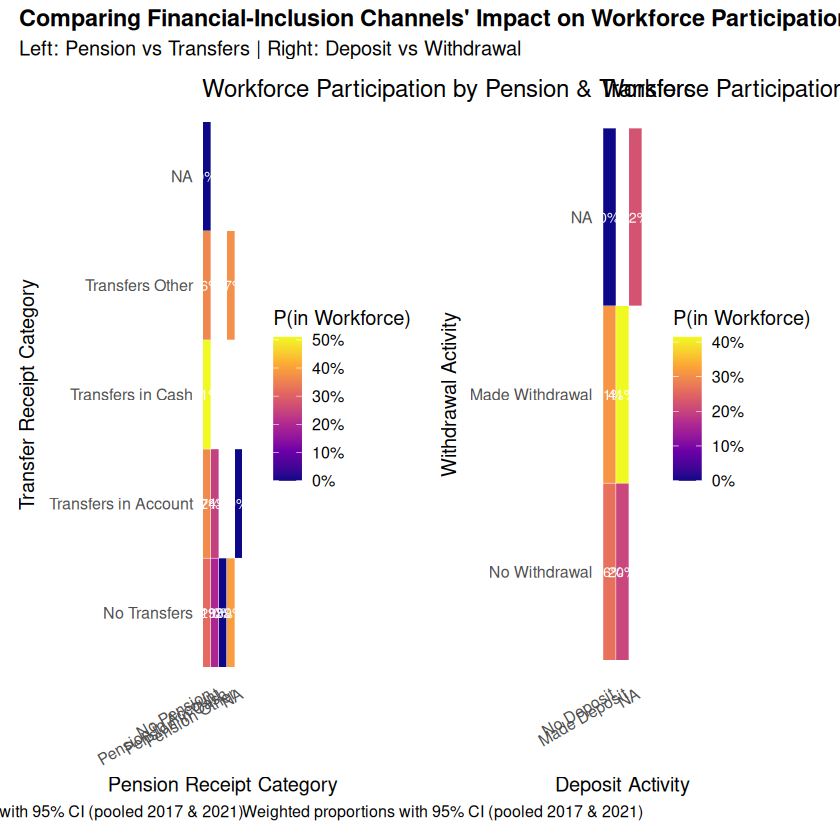

In [17]:
# ================================================================
# Dual Heatmaps: Pension vs Transfers  &  Deposit vs Withdrawal
# Showing predicted P(in workforce) from World Bank GFI (pooled 2017 & 2021)
# ================================================================

# 1. Load required packages
library(tidyverse)
library(srvyr)      # for survey summaries with weights
library(viridis)    # for color-blind-safe palettes
library(patchwork)  # for stitching ggplots side by side
library(scales)     # for percent_format()

# 2. Define survey design with weights
gfi_svy <- gfi_renamed_tbl %>%
  as_survey_design(weights = weight_d)

# 3. Summarize workforce participation by Pension × Transfers
pension_transfer_df <- gfi_svy %>%
  group_by(
    received_government_pension_payment_c,
    received_government_transfers_c
  ) %>%
  summarise(
    p_work    = survey_mean(in_the_workforce_b, vartype = "ci")
  ) %>%
  ungroup() %>%
  mutate(
    pension = factor(
      received_government_pension_payment_c,
      levels = 0:3,
      labels = c(
        "No Pension",
        "Pension in Account",
        "Pension in Cash",
        "Pension Other"
      )
    ),
    transfers = factor(
      received_government_transfers_c,
      levels = 0:3,
      labels = c(
        "No Transfers",
        "Transfers in Account",
        "Transfers in Cash",
        "Transfers Other"
      )
    )
  )

# 4. Summarize workforce participation by Deposit × Withdrawal
deposit_withdraw_df <- gfi_svy %>%
  group_by(
    any_deposit_into_account_b,
    any_withdrawal_from_account_b
  ) %>%
  summarise(
    p_work    = survey_mean(in_the_workforce_b, vartype = "ci")
  ) %>%
  ungroup() %>%
  mutate(
    deposit = factor(
      any_deposit_into_account_b,
      levels = c(0,1),
      labels = c("No Deposit", "Made Deposit")
    ),
    withdrawal = factor(
      any_withdrawal_from_account_b,
      levels = c(0,1),
      labels = c("No Withdrawal", "Made Withdrawal")
    )
  )

# 5. Build Heatmap 1: Pension × Transfers
heatmap1 <- ggplot(pension_transfer_df,
                   aes(x = pension, y = transfers, fill = p_work)) +
  geom_tile(color = "white") +
  geom_text(
    aes(label = percent(p_work, accuracy = 1)),
    color = "white", size = 3
  ) +
  scale_fill_viridis_c(
    name   = "P(in Workforce)",
    labels = percent_format(accuracy = 1),
    option = "C"
  ) +
  labs(
    title = "Workforce Participation by Pension & Transfers",
    x     = "Pension Receipt Category",
    y     = "Transfer Receipt Category",
    caption = "Weighted proportions with 95% CI (pooled 2017 & 2021)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    panel.grid = element_blank()
  )

# 6. Build Heatmap 2: Deposit × Withdrawal
heatmap2 <- ggplot(deposit_withdraw_df,
                   aes(x = deposit, y = withdrawal, fill = p_work)) +
  geom_tile(color = "white") +
  geom_text(
    aes(label = percent(p_work, accuracy = 1)),
    color = "white", size = 3
  ) +
  scale_fill_viridis_c(
    name   = "P(in Workforce)",
    labels = percent_format(accuracy = 1),
    option = "C"
  ) +
  labs(
    title = "Workforce Participation by Deposit & Withdrawal",
    x     = "Deposit Activity",
    y     = "Withdrawal Activity",
    caption = "Weighted proportions with 95% CI (pooled 2017 & 2021)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    panel.grid = element_blank()
  )

# 7. Stitch them side by side
combined_plot <- heatmap1 + heatmap2 + 
  plot_layout(ncol = 2) +
  plot_annotation(
    title = "Comparing Financial‐Inclusion Channels' Impact on Workforce Participation",
    subtitle = "Left: Pension vs Transfers | Right: Deposit vs Withdrawal",
    theme = theme(
      plot.title = element_text(size = 14, face = "bold"),
      plot.subtitle = element_text(size = 12)
    )
  )

# 8. Print combined plot
print(combined_plot)
